# `nb09a`: Model checking

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Now that we can simulate data and fit models, we can evaluate the quality of a model and critically assess whether it is a good fit to data. This is called model checking.

# The light speed experiment 

In 1882, Simon Newcomb conducted an experiment to measure the speed of light. He used a rotating mirror to reflect a beam of light to a distant mirror and back. The time taken for the light to travel to the distant mirror and back was measured by timing the rotation of the mirror. The experiment was repeated several times, and the times taken for the light to travel to the distant mirror and back were recorded as deviations from 24,800 nanoseconds. 

In [3]:
# data
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23]) 

len(light_speed)

66

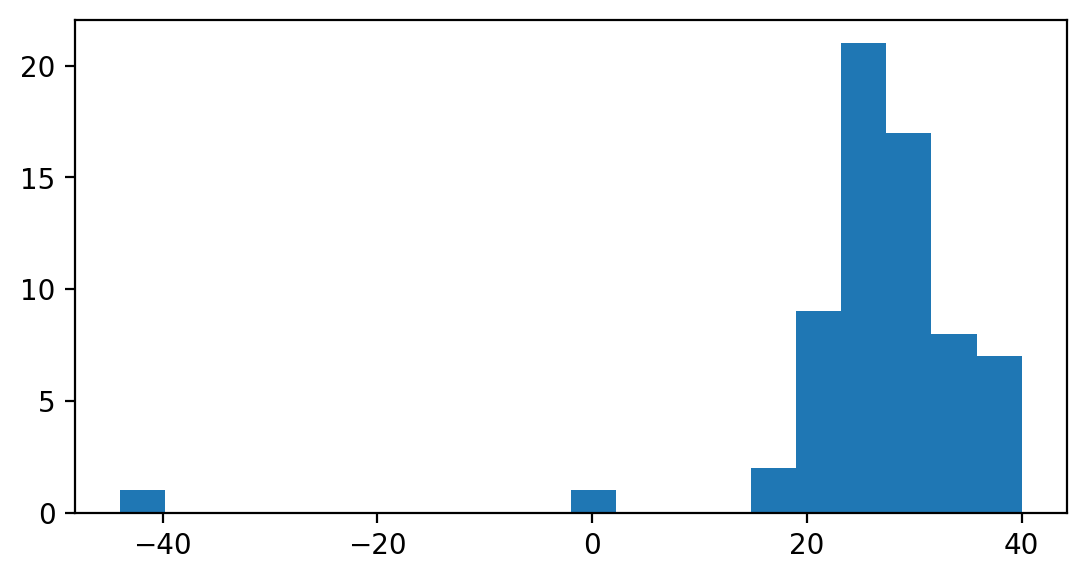

In [4]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()
ax.hist(light_speed, bins=20)
plt.savefig("./figures/lec9/newcomb-data.png")
plt.show()

In [5]:
# Model 1: Gaussian model
from scipy.stats import norm, uniform

def log_likelihood(theta, x):
    mu, sigma = theta
    return norm.logpdf(x, loc=mu, scale=sigma).sum()

def log_prior(theta):   
    mu, sigma = theta

    if not (-1000 <= mu <= 1000):
        return -np.inf
    if not (0.1 <= sigma <= 1000):
        return -np.inf

    return (uniform.logpdf(mu, loc=-1000, scale=2000) +  # p(mu) = U[-1000, 1000]
            uniform.logpdf(sigma, loc=0.1, scale=1000))  # p(sigma) = U[0.1, 1000]

def log_posterior(theta, x):
    return log_likelihood(theta, x) + log_prior(theta)

In [6]:
# Posterior sampling 
import emcee
from scipy.optimize import minimize

def mcmc(log_posterior, n_params, light_speed, n_walkers=10, n_steps=250000):
    mle = minimize(lambda *args: -log_posterior(*args), x0=[10.0] * n_params, args=(light_speed,))
    pos = np.array([mle.x] * n_walkers) + 0.01 * np.random.randn(n_walkers, n_params)
    sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(light_speed,))
    sampler.run_mcmc(pos, n_steps // n_walkers, progress=True)
    return sampler

sampler = mcmc(log_posterior, n_params=2, light_speed=light_speed)

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:48<00:00, 511.89it/s]


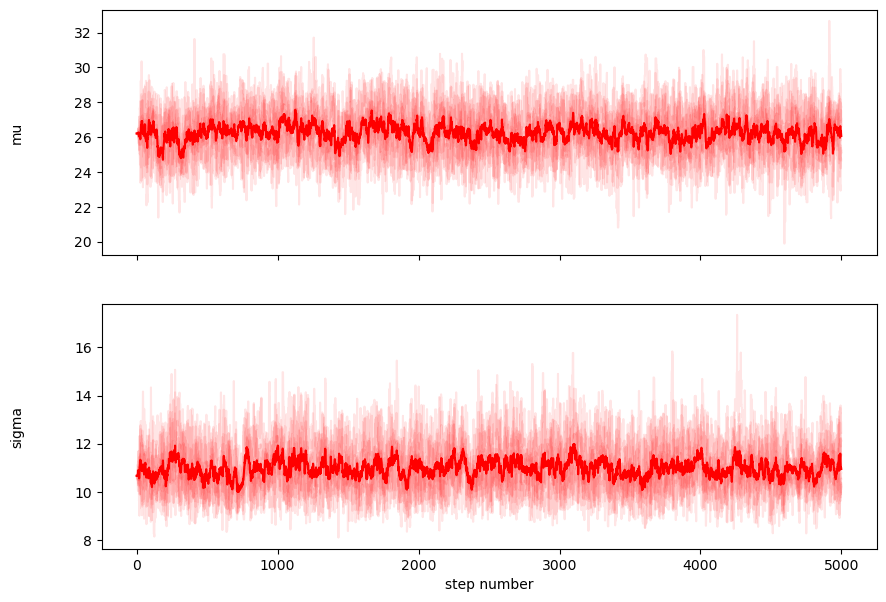

In [7]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]

for i in range(2):
    ax = axes[i]
    ax.plot(samples[:5000, :, i], "r", alpha=0.1)
    ax.plot(np.mean(samples[:5000, :, i], axis=1), "r", alpha=1.0)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [9]:
tau = sampler.get_autocorr_time()
tau

array([33.86187482, 36.23672712])

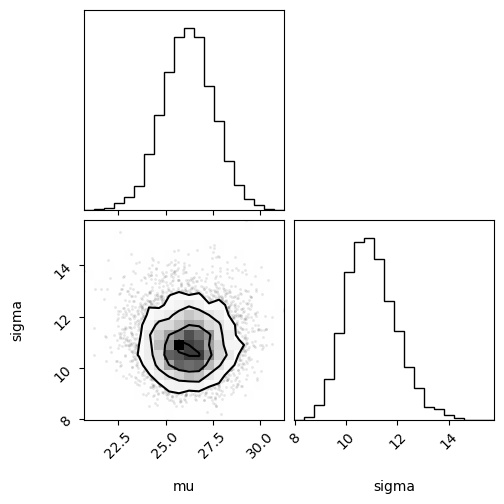

In [10]:
import corner
thetas = sampler.get_chain(flat=True, thin=np.max(tau.astype(int)))
fig = corner.corner(thetas, labels=labels, figsize=(6.4, 6.4), dpi=200)
plt.savefig("./figures/lec9/newcomb-posterior.png")
plt.show()

In [11]:
print("E_p(mu|x)[mu] =", np.mean(thetas[:, 0]))
print("E_p(sigma|x)[sigma] =", np.mean(thetas[:, 1]))

E_p(mu|x)[mu] = 26.196337379630286
E_p(sigma|x)[sigma] = 10.975390744899192


In [12]:
print("Empirical mean =", np.mean(light_speed))
print("Empirical std =", np.std(light_speed))

Empirical mean = 26.21212121212121
Empirical std = 10.663610099255504


<div class="alert alert-success">
    
**Exercise**. Determine the 95% credibility interval for $\mu$ and $\sigma$.
    
</div>

A (highest posterior density) 95% credibility interval is the shortest interval that contains 95% of the posterior probability.

In [13]:
def hpd(trace, mass_frac) :
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n-n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int+n_samples]])

low, high = hpd(thetas[:, 0], 0.95)
low, high

(23.69106372794206, 29.002882240364375)

In [14]:
24800+low, 24800+high

(24823.691063727943, 24829.002882240366)

Note: The currently accepted estimate of the speed of light under the conditions of the experiment corresponds to a measurement of 24833.02 nanoseconds.

# Posterior predictive distribution

$$p(x^\text{rep} | \{x\}) = \int p(x^\text{rep} | \theta) p(\theta | \{x\}) d\theta$$

In [15]:
thetas = thetas[:1000]

def pp(thetas):
    return norm.rvs(loc=thetas[:, 0], scale=thetas[:, 1])

$$p(\{x^\text{rep}\} | \{x\}) = \int p(\{x^\text{rep}\} | \theta) p(\theta | \{x\}) d\theta$$

In [16]:
def replicate(n_samples, thetas):
    x = np.zeros((n_samples, len(thetas)))
    
    for i in range(n_samples):
        x[i] = pp(thetas)
    
    return x

In [17]:
replicas = replicate(66, thetas)

In [18]:
replicas.shape

(66, 1000)

## Visual inspection of posterior predictives

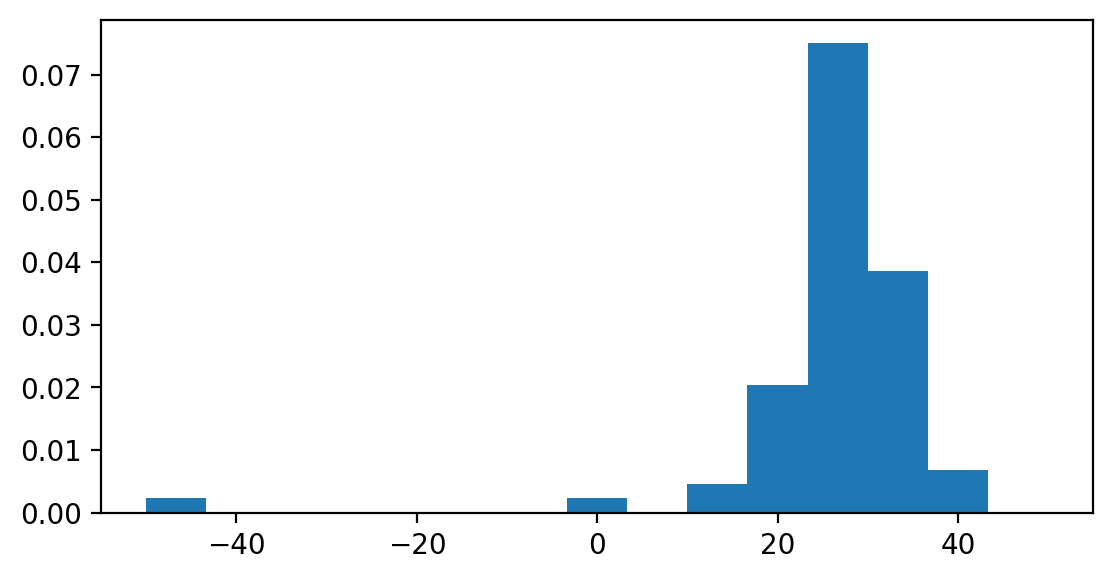

In [19]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()
ax.hist(light_speed, bins=15, range=(-50, 50), density=True)
plt.show()

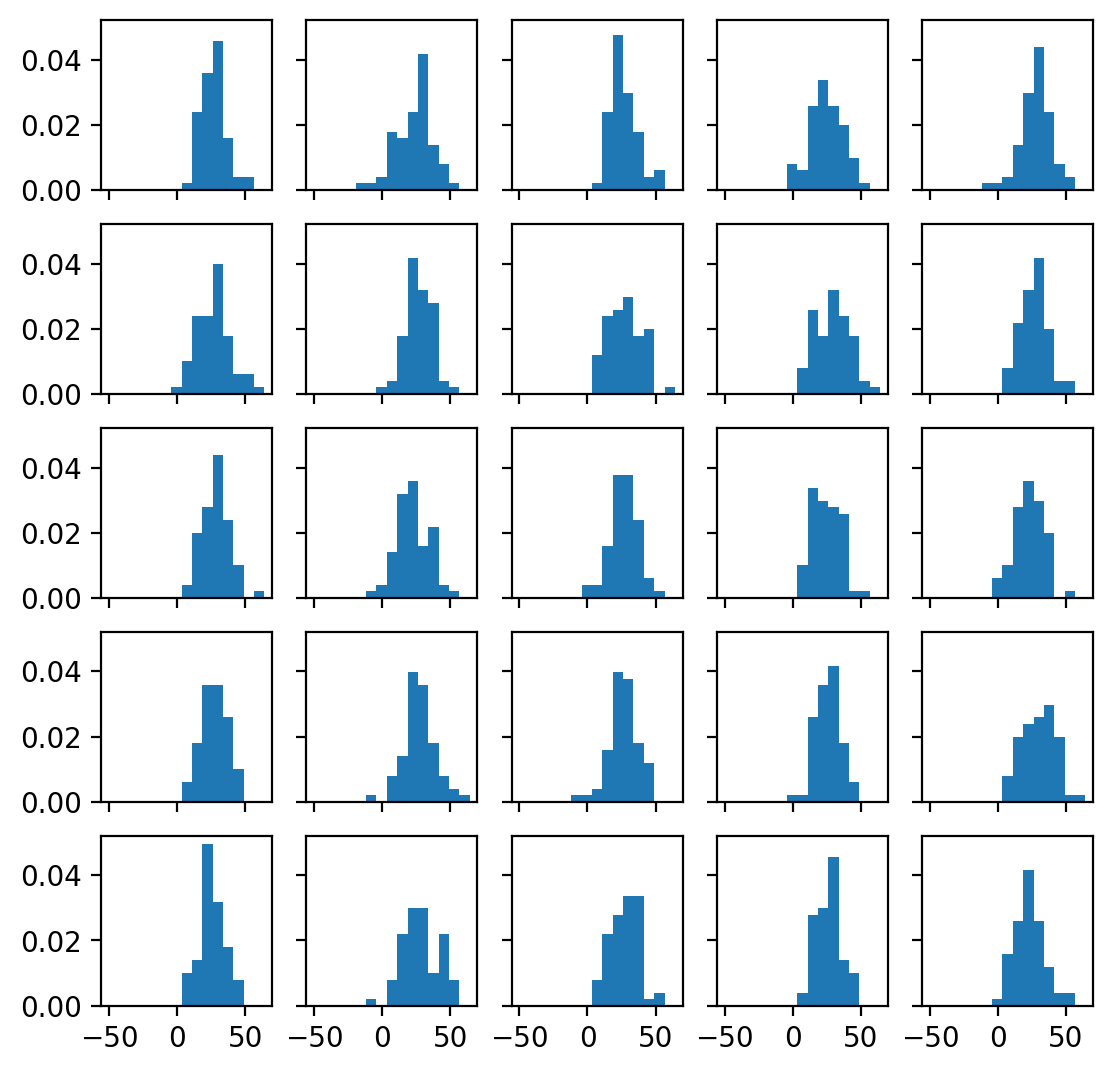

In [21]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(6.4, 6.4), dpi=200)
lower = -50
upper = np.max(replicas[:, :25])
for k in range(25):
    ax[k // 5, k % 5].hist(replicas[:, k], bins=15, range=(lower, upper), density=True)
plt.savefig("./figures/lec9/newcomb-replicates.png")
plt.show()

## Test quantities

Statistics 101: _There is only one test!_
1. Given the data, compute a test statistic that measures some aspect of the data.
2. Compute the distribution of the test statistic under the model.
3. Compare the observed test statistic to the distribution of the test statistic under the model, usually in terms of a p-value.

Forget about statistical recipes! They have been invented when computers were not available, i.e. when Step 2 was not something we could simply do by simulation.

In [22]:
light_speed.mean()

26.21212121212121

In [23]:
replicas.mean(axis=0)

array([26.70127976, 24.01233804, 26.41414276, 24.79565763, 28.14643572,
       27.10663077, 26.72403606, 27.65530679, 29.34331326, 26.33246477,
       28.27591677, 22.25946787, 26.61006919, 25.09008588, 22.88272698,
       27.33274406, 27.09927151, 26.51163507, 25.41528878, 29.43820653,
       25.58979537, 28.43073208, 26.82161911, 26.34661863, 23.57952091,
       24.92899151, 25.82156405, 28.45676001, 24.52319384, 27.38838359,
       28.33603173, 29.0189857 , 22.8887307 , 26.18057579, 24.1027834 ,
       27.91139597, 25.39147295, 23.24242938, 25.38333348, 25.7640486 ,
       25.29261822, 27.82692692, 21.88029087, 24.47884483, 24.71889075,
       25.50178417, 26.67790695, 26.38169167, 27.70211335, 24.44013164,
       26.6772159 , 27.29566766, 24.73080306, 26.77662624, 25.77479015,
       26.42100528, 25.55156249, 27.81219064, 24.56856707, 26.68709283,
       25.0129301 , 27.09240831, 24.47278707, 22.94653082, 25.88772081,
       27.24369425, 28.09061339, 27.99471396, 27.88564616, 25.11

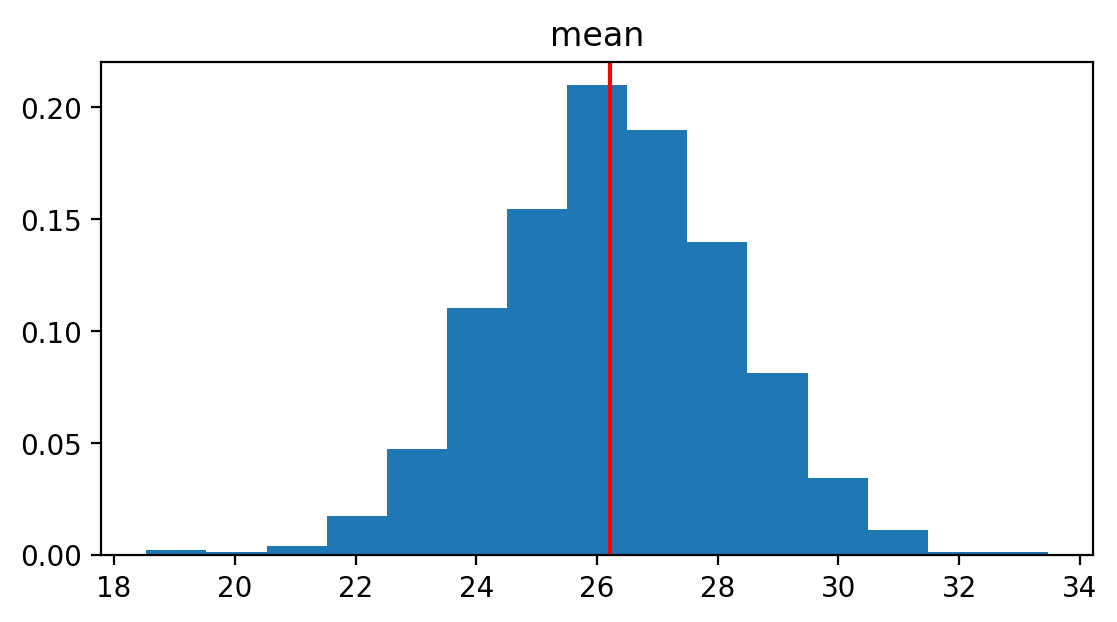

0.521

In [25]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()

ax.set_title("mean")
ax.hist(replicas.mean(axis=0), bins=15, density=True)
ax.axvline(light_speed.mean(), color="r")

plt.savefig("./figures/lec9/newcomb-replicate-means.png")
plt.show()

pval = (replicas.mean(axis=0) >= light_speed.mean()).mean()
pval

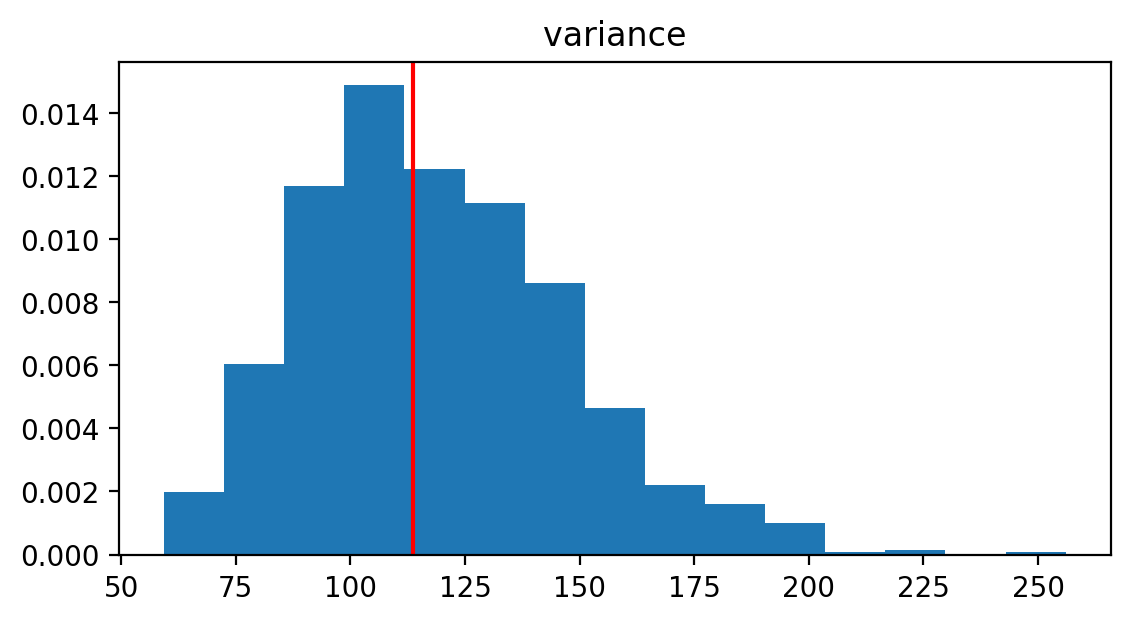

0.523

In [26]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()

ax.set_title("variance")
ax.hist(replicas.var(axis=0), bins=15, density=True)
ax.axvline(light_speed.var(), color="r")

plt.savefig("./figures/lec9/newcomb-replicate-vars.png")
plt.show()

pval = (replicas.var(axis=0) >= light_speed.var()).mean()
pval

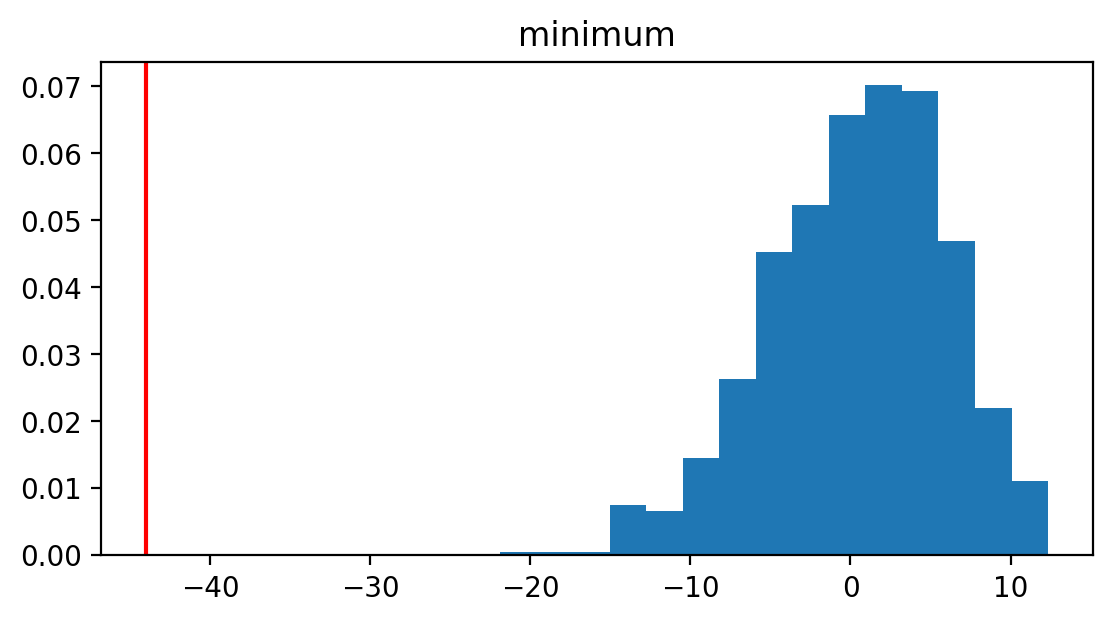

1.0

In [27]:
fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()

ax.set_title("minimum")
ax.hist(replicas.min(axis=0), bins=15, density=True)
ax.axvline(light_speed.min(), color="r")

plt.savefig("./figures/lec9/newcomb-replicate-mins.png")
plt.show()

pval = (replicas.min(axis=0) >= light_speed.min()).mean()
pval

In [28]:
np.mean(replicas.min(axis=0) >= light_speed.min())

1.0

This suggests that the normal distribution is not adequate to model the data. Its tails are too light.

## Residual analysis

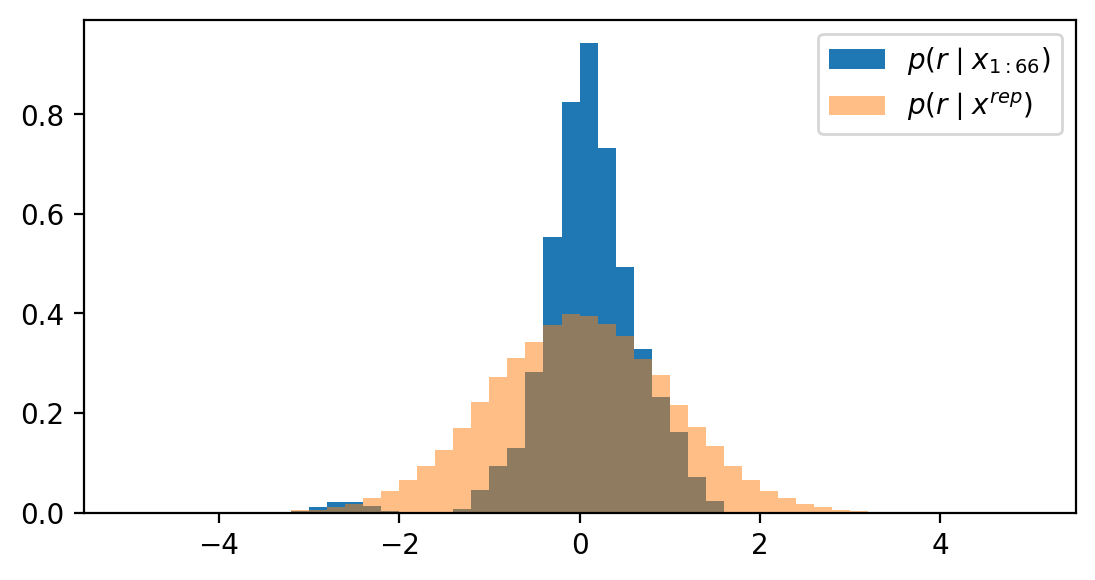

In [31]:
residuals = (light_speed[:, np.newaxis] - thetas[np.newaxis, :, 0]) / thetas[np.newaxis, :, 1]
residuals_rep = (replicas - thetas[np.newaxis, :, 0]) / thetas[np.newaxis, :, 1]

fig = plt.figure(figsize=(6.4, 3.2), dpi=200)
ax = plt.axes()
ax.hist(residuals.flatten(), bins=50, range=(-5, 5), density=True, label=r"$p(r \mid x_{1:66})$")
ax.hist(residuals_rep.flatten(), bins=50, range=(-5, 5), alpha=0.5, density=True, label=r"$p(r \mid x^{rep})$")
ax.legend()

plt.savefig("./figures/lec9/newcomb-residuals.png")
plt.show() 

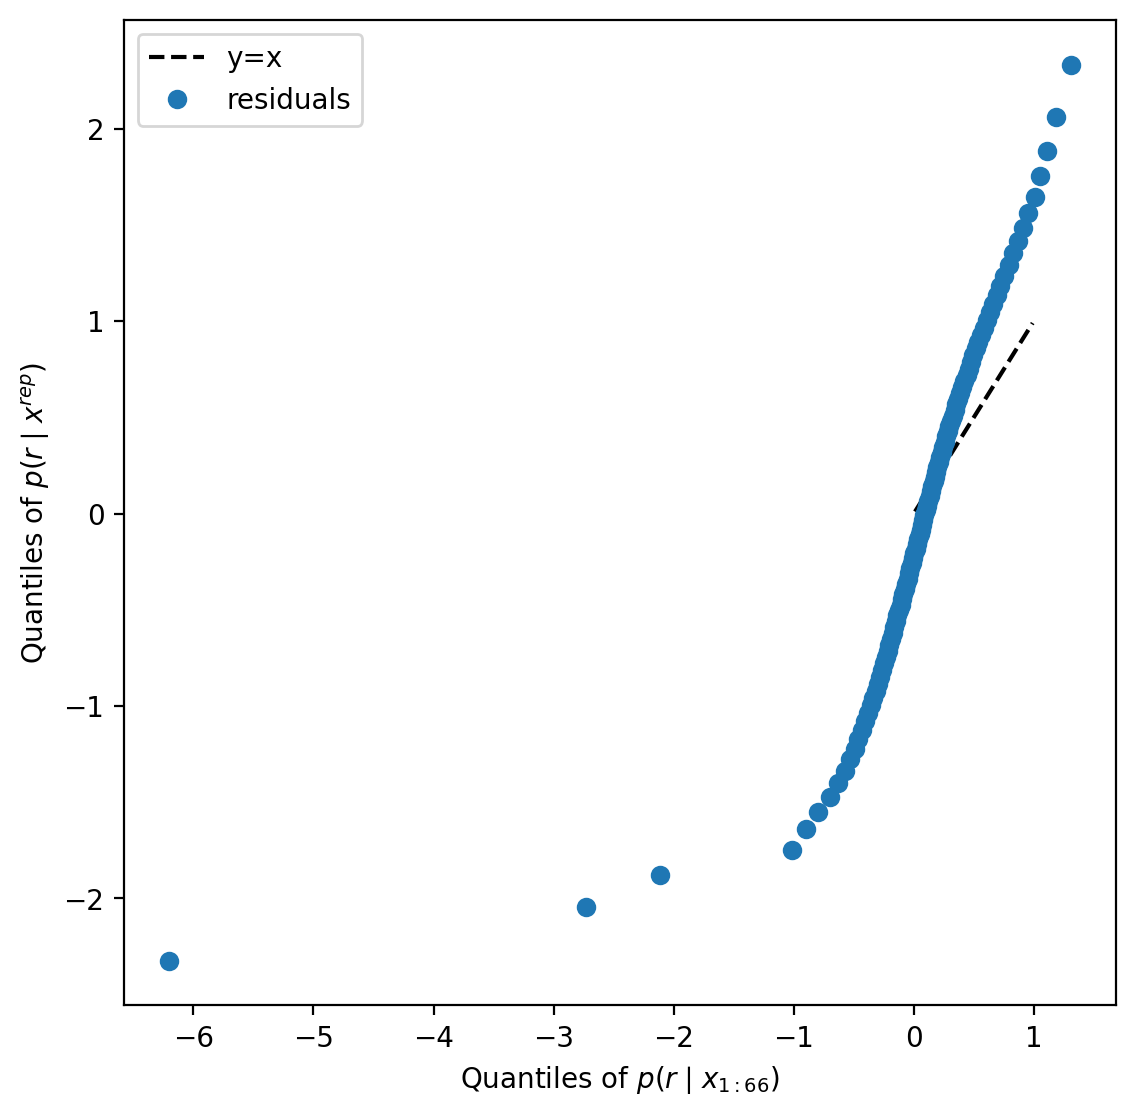

In [30]:
# QQ plot
quantiles = np.linspace(0.01, 0.99, 100)
residuals_sorted = np.sort(residuals.flatten())
residuals_rep_sorted = np.sort(residuals_rep.flatten())

fig = plt.figure(figsize=(6.4, 6.4), dpi=200)
ax = plt.axes()
ax.plot(quantiles, quantiles, "k--", label="y=x")
ax.plot(np.percentile(residuals_sorted, quantiles*100),
        np.percentile(residuals_rep_sorted, quantiles*100),
        "o", label="residuals")
ax.set_xlabel("Quantiles of $p(r \mid x_{1:66})$")
ax.set_ylabel("Quantiles of $p(r \mid x^{rep})$")
ax.legend()
plt.savefig("./figures/lec9/newcomb-qqplot.png")
plt.show()